## Lightning Density 
While you are quantifying # of strikes per 10 min interval, I think to compare within storms you need to also compute the density of lightning (with the method Jacob suggested in one of our meetings). That would standardize by the coverage area.

Number or number density? 
- Strikes per unit area 
- How close together lightning strikes are 
- Minimum distance between strikes to show proximity 
- Per square km area how many strikes
- 2d histogram bins of strikes of km
- Make a 5 x 5 km box and plot lightning strikes within that time, then slide the region by 1 km and do it again 
- 
- 
- The moving box is like recreating a grid, one box = one grid square, do this multiple times to cover whole grid 
- Calculate distance between lightning strikes 


# imports & data

In [17]:
# import all packages that are needed 

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import metpy  
import xarray
import pandas as pd

import cartopy
import cartopy.crs as ccrs
from pymatreader import read_mat
import matplotlib.patches as mpatches

import os
import matplotlib.patches as mpatches
from shapely import geometry
from textwrap import wrap

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable

#for distance between points
import math
from itertools import combinations

## import data

In [2]:
# read in the data 

A = read_mat('/data/edworak/data/2021-06-28-Bortnik.mat')
df_a = pd.DataFrame(A['Events'], columns = ["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak-current", "j",  "k", "l", "m"])
june28_og = df_a.loc[:, ~df_a.columns.isin(["j",  "k", "l", "m"])]

june28 = pd.DataFrame(june28_og)
polarity = []
for i in range(len(june28_og)): 
    if june28["peak-current"][i] > 0:
           polarity.append("+")
    elif june28["peak-current"][i] < 0:
           polarity.append("-")
june28['polarity'] = polarity


B = read_mat('/data/edworak/data/2021-06-29-Bortnik.mat')
df_b = pd.DataFrame(B['Events'], columns = ["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak-current", "j",  "k", "l", "m"])
june29_og = df_b.loc[:, ~df_b.columns.isin(["j",  "k", "l", "m"])]

june29 = pd.DataFrame(june29_og)
polarity = []
for i in range(len(june29_og)): 
    if june29["peak-current"][i] > 0:
           polarity.append("+")
    elif june29["peak-current"][i] < 0:
           polarity.append("-")
june29['polarity'] = polarity


C = read_mat('/data/edworak/data/2021-06-30-Bortnik.mat')
df_c = pd.DataFrame(C['Events'], columns = ["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak-current", "j",  "k", "l", "m"])
june30_og = df_c.loc[:, ~df_c.columns.isin(["j",  "k", "l", "m"])]

june30 = pd.DataFrame(june30_og)
polarity = []
for i in range(len(june30_og)): 
    if june30["peak-current"][i] > 0:
           polarity.append("+")
    elif june30["peak-current"][i] < 0:
           polarity.append("-")
june30['polarity'] = polarity


D = read_mat('/data/edworak/data/2021-07-01-Bortnik.mat')
df_d = pd.DataFrame(D['Events'], columns = ["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak-current", "j",  "k", "l", "m"])
july1_og = df_d.loc[:, ~df_d.columns.isin(["j",  "k", "l", "m"])]

july1 = pd.DataFrame(july1_og)
polarity = []
for i in range(len(july1_og)): 
    if july1["peak-current"][i] > 0:
           polarity.append("+")
    elif july1["peak-current"][i] < 0:
           polarity.append("-")
july1['polarity'] = polarity


In [3]:
# june 30 hour 21 to july 1 hour 5
june30_21to24 = june30[(june30["hour"] >= 21) & (june30["hour"] <= 24)]
july1_0to5 = july1[(july1["hour"] >= 0) & (july1["hour"] <= 5.0)]
frames1 = [june30_21to24, july1_0to5]
june30_july1_concat = pd.concat(frames1)

frames2 = [june29, june30, july1]
whole_concat = pd.concat(frames2)

frames3 = [june28, june29, june30, july1]
alldays_concat = pd.concat(frames3)

In [6]:
july1

,year,month,day,hour,minute,second,lat,lon,peak-current,polarity
0,2021.0,7.0,1.0,0.0,0.0,0.012910,53.275752,-121.560469,3.0,+
1,2021.0,7.0,1.0,0.0,0.0,2.546976,53.270097,-121.567163,6.0,+
2,2021.0,7.0,1.0,0.0,0.0,2.635429,51.627081,-120.937201,-28.0,-
3,2021.0,7.0,1.0,0.0,0.0,2.696911,51.606372,-120.935466,-7.0,-
4,2021.0,7.0,1.0,0.0,0.0,3.462926,53.253957,-121.538408,8.0,+
...,...,...,...,...,...,...,...,...,...,...
802165,2021.0,7.0,1.0,23.0,59.0,56.824909,45.922268,-116.690831,5.0,+
802166,2021.0,7.0,1.0,23.0,59.0,56.964276,55.191186,-119.930294,7.0,+
802167,2021.0,7.0,1.0,23.0,59.0,57.925225,50.564143,-117.615571,3.0,+
802168,2021.0,7.0,1.0,23.0,59.0,58.699633,54.381751,-119.048094,7.0,+


## for loop: time nested


In [62]:
hours = [22.0, 23.0, 0.0, 1.0, 2.0]
mins = range(0, 60, 10)
lat_pyrocb_nested = []
lon_pyrocb_nested = []


for i in range(len(hours)): 
    for j in range(len(mins)): 
        time = june30_july1_concat[(june30_july1_concat["hour"] == hours[i]) & (june30_july1_concat["minute"] >= mins[j]) & (june30_july1_concat["minute"] <= mins[j] + 9)]
        data_pyrocb = (time.loc[(time.lon >= -121.3) & (time.lon <= -120.6) & (time.lat >= 51.2) & (time.lat <= 52.4)])
        if len(data_pyrocb) > 1: 
            lon_pyrocb_nested.append(np.array(data_pyrocb["lon"]))
            lat_pyrocb_nested.append(np.array(data_pyrocb["lat"]))

lon_pyrocb = [item for sublist in lon_pyrocb_nested for item in sublist]
lat_pyrocb = [item for sublist in lat_pyrocb_nested for item in sublist]


## for loop: region nested
- seperate by region not time 
- divide by 0.1 degree? 
- 111 km per degree of latitude or longitude 
- 11.1 km per 0.1 degree 
- 5.55 km per 0.05 degree
- 
- lon: -121.3, -120.6 
- lat: 51.2, 52.4

In [56]:
# bottomLeft = (-121.3, 51.2)
# bottomRight = (-120.6, 51.2)
# topLeft = (-121.3, 52.4)
# topRight = (-120.6, 52.4)

bottomLeft = (51.2, -121.3)
bottomRight = (51.2, -120.6)
topLeft = (52.4, -120.6)
topRight = (52.4, -121.3)

cols = np.linspace(bottomLeft[1], bottomRight[1], num=14)
rows = np.linspace(bottomLeft[0], topLeft[0], num=24)

june30_july1_concat['col'] = np.searchsorted(cols, june30_july1_concat['lon'])
june30_july1_concat['row'] = np.searchsorted(rows, june30_july1_concat['lat'])
june30_july1_concat['col']

489437     0
489438     0
489439     0
489440     0
489441     0
          ..
304994     7
304995    11
304996     8
304997     5
304998    11
Name: col, Length: 307048, dtype: int64

In [67]:
lon_pyrocb = np.linspace(-121.3, -120.6, 14)
lat_pyrocb = np.linspace(51.2, 52.4, 24)

lon_empty = []
lat_empty = []

for i in range(len(lon_pyrocb_nested)): 
    for j in range(len(lat_pyrocb_nested)):
        print(lon_pyrocb[i])
        data_pyrocb = june30_july1_concat[(june30_july1_concat.lon >= lon_pyrocb[i]) & (june30_july1_concat.lon < lon_pyrocb[i] + 0.05) &(june30_july1_concat.lat >= lat_pyrocb[j]) & (june30_july1_concat.lat < lat_pyrocb[j] + 0.05)]
        #data_pyrocb = (time.loc[(time.lon >= -121.5) & (time.lon <= -119) & (time.lat >= 51) & (time.lat <= 53)])
        if len(data_pyrocb) > 1: 
            lon_empty.append(np.array(data_pyrocb["lon"]))
            lat_empty.append(np.array(data_pyrocb["lat"]))

lon_grid_array = [item for sublist in lon_empty for item in sublist]
lat_grid_array = [item for sublist in lat_empty for item in sublist]

lon_grid_array

-121.3
-121.3
-121.3
-121.3
-121.3
-121.3
-121.3
-121.3
-121.3
-121.3
-121.3
-121.3
-121.3
-121.3
-121.3
-121.3
-121.3
-121.3
-121.3
-121.3
-121.3
-121.24615384615385
-121.24615384615385
-121.24615384615385
-121.24615384615385
-121.24615384615385
-121.24615384615385
-121.24615384615385
-121.24615384615385
-121.24615384615385
-121.24615384615385
-121.24615384615385
-121.24615384615385
-121.24615384615385
-121.24615384615385
-121.24615384615385
-121.24615384615385
-121.24615384615385
-121.24615384615385
-121.24615384615385
-121.24615384615385
-121.24615384615385
-121.1923076923077
-121.1923076923077
-121.1923076923077
-121.1923076923077
-121.1923076923077
-121.1923076923077
-121.1923076923077
-121.1923076923077
-121.1923076923077
-121.1923076923077
-121.1923076923077
-121.1923076923077
-121.1923076923077
-121.1923076923077
-121.1923076923077
-121.1923076923077
-121.1923076923077
-121.1923076923077
-121.1923076923077
-121.1923076923077
-121.1923076923077
-121.13846153846154
-121.138461538

IndexError: index 14 is out of bounds for axis 0 with size 14

# map 

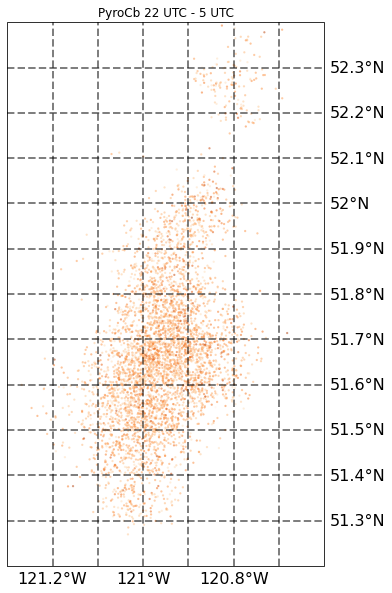

In [30]:
fig = plt.figure(figsize=(10,10))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")


# Make figure larger
plt.xlim([-121.3, -120.6])
plt.ylim([51.2, 52.4])


points_pos = (june30_july1_concat.loc[(june30_july1_concat.lon > -121.3) & (june30_july1_concat.lon < -120.6) & (june30_july1_concat.lat > 51.2) & (june30_july1_concat.lat < 52.4) ])# & (june30_july1_concat["hour"] <=1)])

plt.scatter(x = points_pos["lon"], y = points_pos["lat"], c = np.log(points_pos["peak-current"]), cmap="Oranges", s = 5, edgecolors="none", marker = 'o', alpha=0.5)


# add grid lines 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([ -121.2, -121.1, -121, -120.9, -120.8, -120.7])
gl.ylocator = mticker.FixedLocator([51.3, 51.4, 51.5, 51.6, 51.7, 51.8, 51.9, 52.0, 52.1, 52.2, 52.3])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'

plt.title("PyroCb 22 UTC - 5 UTC")

# plt.savefig("pos_neg_map", dpi = 200)

plt.show()

# distance between points

## average distance between points

In [12]:
def dist(p1, p2):
    (x1, y1), (x2, y2) = p1, p2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

x = lat_pyrocb
y = lon_pyrocb

points = list(zip(x,y))
distances = [dist(p1, p2) for p1, p2 in combinations(points, 2)]
avg_distance = sum(distances) / len(distances)

In [13]:
avg_distance

0.2137852443355499

## loop over disntace between points 

In [40]:
lat_pyrocb_nested

[array([51.322048, 51.334298, 51.331426, 51.329715, 51.319729, 51.307818,
        51.308671, 51.308859, 51.309293, 51.321447, 51.292074, 51.34245 ,
        51.318514, 51.307739, 51.304136, 51.310013]),
 array([51.364173, 51.318756, 51.319955, 51.327311, 51.341979, 51.333683,
        51.343003, 51.341173, 51.324203, 51.30585 , 51.342788, 51.299389,
        51.330057, 51.358105, 51.311598, 51.3512  , 51.314176, 51.290684,
        51.334715, 51.326604, 51.315812, 51.346026, 51.337683, 51.374934,
        51.301582, 51.347566, 51.344533, 51.352105, 51.311024, 51.317738,
        51.310106, 51.293375, 51.313343, 51.364611, 51.341463, 51.363029,
        51.330887, 51.294058, 51.308948, 51.331085, 51.368545, 51.312961,
        51.349892, 51.326928, 51.352036, 51.332522, 51.346398, 51.308145,
        51.334158, 51.329667, 51.352429, 51.324388, 51.352726, 51.346733,
        51.358002, 51.326321, 51.366588, 51.360762, 51.359935, 51.356527,
        51.340162, 51.362722, 51.299095, 51.298221, 51.332

In [71]:
def avg_distance(x,y):
    n = len(x)
    dist = 0
    for i in range(n):
        for j in range(n):
        xi = x[i][j]
        #print(xi)
        yi = y[i][j]
        for k in range(j+1, n):
            dx = x[i][k]-xi
            dy = y[i][k]-yi
            dist += sqrt(dx*dx+dy*dy)
    #return the sum of all distances calculated 
    return 2.0*dist/(n*(n-1))

In [73]:
avg_distance(lat_pyrocb_nested, lon_pyrocb_nested)

## not working to distinguish by time since not same number of strikes in each interval, can't do direct comparison? 

ValueError: operands could not be broadcast together with shapes (179,) (16,) 